In [3]:
import sys
import os

# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)


# Implied Volatility 

This notebook demonstrates:
1. Computing implied volatility from option market prices.
2. Building a volatility smile (across strikes).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from options_pricing.black_scholes import black_scholes_price
from options_pricing.volatility import implied_volatility, implied_vol_surface


## 1. Implied Volatility of a Single Option


In [7]:
S, K, T, r, sigma_true = 100, 100, 1.0, 0.05, 0.25

price = black_scholes_price(S, K, T, r, sigma_true, option_type="call")
sigma_est = implied_volatility(price, S, K, T, r, option_type="call")

print(f"True σ = {sigma_true:.4f}")
print(f"Implied σ = {sigma_est:.4f}")


True σ = 0.2500
Implied σ = 0.2500


## 2. Volatility Smile
We simulate “market” imperfections by adding 5% random noise to option prices.
Implied volatilities will now deviate from the true flat σ.


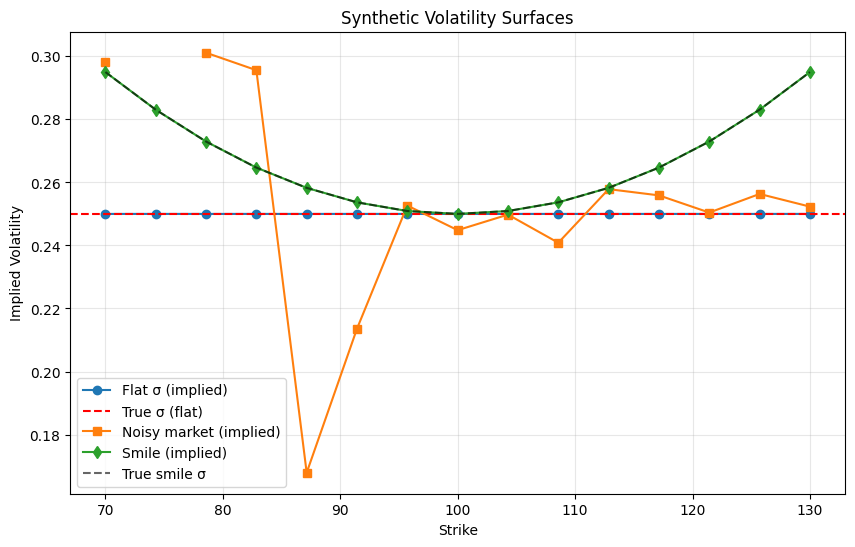

In [10]:
# Add random noise to prices
rng = np.random.default_rng(42)
prices_noisy = [p * (1 + 0.05 * rng.standard_normal()) for p in prices_flat]
strikes = np.linspace(70, 130, 15)

# Recover implied volatilities
ivols_noisy = [implied_volatility(p, S, K, T, r, "call") for p, K in zip(prices_noisy, strikes)]


# Prices under constant volatility
prices_flat = [black_scholes_price(S, K, T, r, sigma_true, "call") for K in strikes]

# Back out implied volatility
ivols_flat = [implied_volatility(p, S, K, T, r, "call") for p, K in zip(prices_flat, strikes)]


sigma0, alpha = 0.25, 2.0
def smile_vol(K):
    return sigma0 * (1 + alpha * ((K - S)/S)**2)

# True vols and prices under smile
true_vols_smile = [smile_vol(K) for K in strikes]
prices_smile = [black_scholes_price(S, K, T, r, smile_vol(K), "call") for K in strikes]

# Implied vols from smile prices
ivols_smile = [implied_volatility(p, S, K, T, r, "call") for p, K in zip(prices_smile, strikes)]




prices = [black_scholes_price(S, K, T, r, sigma_true, "call") for K in strikes]
ivols = np.array([implied_volatility(p, S, K, T, r, "call") for p, K in zip(prices, strikes)])
ivols = np.round(ivols, 4)
ivols = np.where((ivols > 0) & (ivols < 5), ivols, np.nan)

valid = ~np.isnan(ivols)



plt.figure(figsize=(10,6))

# Case 1: Flat σ
plt.plot(strikes, ivols_flat, "o-", label="Flat σ (implied)")
plt.axhline(sigma_true, color="red", linestyle="--", label="True σ (flat)")

# Case 2: Noisy prices
plt.plot(strikes, ivols_noisy, "s-", label="Noisy market (implied)")

# Case 3: Smile
plt.plot(strikes, ivols_smile, "d-", label="Smile (implied)")
plt.plot(strikes, true_vols_smile, "k--", alpha=0.6, label="True smile σ")

plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Synthetic Volatility Surfaces")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
